# Combined Drought Indicator

downlaod link : 
-  https://edo.jrc.ec.europa.eu/gdo/php/index.php?id=2112 



In [1]:
directory = '/Users/arthurcalvi/Data/Disturbances_maps/Copernicus_CDI'
out_directory = '/Users/arthurcalvi/Data/Disturbances_maps/Copernicus_CDI/CDI_2012_2023'

#put all of the .tif files inside subfolders into a single folder in out directory 
import os
os.makedirs(out_directory, exist_ok=True)
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.tif'):
            os.rename(os.path.join(root, file), os.path.join(out_directory, file))




In [6]:
#crop raster to the extent of france 
from shapely.geometry import Polygon

extent_france_epsg4326 = [-5.493164,41.211722,9.975586,51.399206]
polygon = Polygon([(-5.493164,41.211722),(-5.493164,51.399206),(9.975586,51.399206),(9.975586,41.211722)])
#transform to epsg 3035 with rasterio.warp.transform_geom
from rasterio.warp import transform_geom

polygon_3035 = transform_geom('EPSG:4326', 'EPSG:3035', polygon.__geo_interface__)

#open every raster in out_directory with a window and crop it to the extent of france, then save them to a new directory
import rasterio
import rasterio.mask

new_directory = '/Users/arthurcalvi/Data/Disturbances_maps/Copernicus_CDI/CDI_2012_2023/france_extent'
os.makedirs(new_directory, exist_ok=True)

for root, dirs, files in os.walk(out_directory):
    for file in files:
        if file.endswith('.tif'):
            with rasterio.open(os.path.join(root, file)) as src:
                assert src.crs == rasterio.crs.CRS.from_epsg(3035)
                out_image, out_transform = rasterio.mask.mask(src, [polygon_3035], crop=True)
                out_meta = src.meta
                out_meta.update({"driver": "GTiff",
                                 "height": out_image.shape[1],
                                 "width": out_image.shape[2],
                                 "transform": out_transform})
                with rasterio.open(os.path.join(new_directory, file), "w", **out_meta) as dest:
                    dest.write(out_image)

In [4]:
#convert each france extent raster to geodataframe and save it to a new directory
#only keep the polygons with a value of 3
import geopandas as gpd
import rasterio
import rasterio.features
from shapely.geometry import shape
from tqdm import tqdm
from datetime import datetime
import os
fr = gpd.read_parquet('../data/processed_datasets/france_EPSG2154.parquet')
new_directory = '/Users/arthurcalvi/Data/Disturbances_maps/Copernicus_CDI/CDI_2012_2023/france_extent'
list_gdf = []
for root, dirs, files in os.walk(new_directory):
    for file in tqdm(files):
        if file.endswith('.tif'):
            date = file.split('_')[3]
            date = datetime.strptime(date, '%Y%m%d')
            with rasterio.open(os.path.join(root, file)) as src:
                image = src.read(1)
                shapes = rasterio.features.shapes(image, transform=src.transform)
                geoms = [shape(s) for s, val in shapes if val == 4]
                gdf = gpd.GeoDataFrame({'geometry':geoms, 'date': [date] * len(geoms)}, geometry='geometry', crs=src.crs)
                gdf = gdf.to_crs('epsg:2154').clip(fr.geometry)
                list_gdf.append(gdf)
                

100%|██████████| 424/424 [10:31<00:00,  1.49s/it]


In [35]:
#check if a drought alert (3) is followed by partial recovery (4)

import rasterio
from tqdm import tqdm
from datetime import datetime
import os
list_images =[]
list_dates = []
new_directory = '/Users/arthurcalvi/Data/Disturbances_maps/Copernicus_CDI/CDI_2012_2023/france_extent'
for root, dirs, files in os.walk(new_directory):
    for file in tqdm(sorted(files)):
        if file.endswith('.tif'):
            image = rasterio.open(os.path.join(root, file)).read(1)
            list_images.append(image)
            date = file.split('_')[3]
            date = datetime.strptime(date, '%Y%m%d')
            list_dates.append(date)

  0%|          | 0/424 [00:00<?, ?it/s]

100%|██████████| 424/424 [00:02<00:00, 149.84it/s]


In [198]:
# import numpy as np
# def check_drought_recovery(images, steps=10*3*6):
#     partial_recovery = (images[-1] == 4)

#     droughts = np.zeros_like(images[-1], dtype=bool)
#     for i in range(1, min(len(images), steps)):
#         alerts = (images[-i] == 3) 
#         droughts = (alerts & partial_recovery) | droughts

#     return droughts 

# droughts = check_drought_recovery(list_images[:10*3*6], steps=10*3*3)
    
import numpy as np

def count_occurrences(images, value, min_count, start, end, strict=False):
    """
    Count the occurrences of a specific value in the images within a specified range.
    Returns a boolean mask where True indicates the value occurs at least min_count times.
    """
    if strict :
        count = sum((images[i] == value) for i in range(start, min(end, len(images))))
    else :
        count = sum((images[i] >= value) for i in range(start, min(end, len(images))))
    return count >= min_count

def check_drought_recovery(images, recovery_period=10, alert_period=10, period = 12):
    """
    Check for pixels that meet the criteria of partial recovery during a period and 
    alert in a specified past period.
    """
    # Constants for steps (assuming images are taken every 10 days)
    steps_per_month = 3  # 10 days per frame, so 3 frames per month
    period_steps = period * steps_per_month

    # print(0)
    # print(len(images) / 3 - 2 * recent_months) 
    # print(len(images) / 3 - recent_months)
    # print(len(images) / 3) 
    # Count occurrences of partial recovery in the recent period
    recovery_mask = count_occurrences(images, value=4, min_count=recovery_period, 
                                      start=len(images)-period_steps, end=len(images), strict=True)

    # Count occurrences of alerts in the specified past period
    alert_mask = count_occurrences(images, value=2, min_count=alert_period, 
                                   start=0, end=len(images) - period_steps)

    return recovery_mask & alert_mask

def generate_drought_maps(images, list_dates, recovery_period=5, alert_period=10, interval_months=12):
    """
    Generate drought maps every specified number of months.
    """
    drought_maps = []
    steps_per_month = 3  # 10 days per frame, so 3 frames per month
    interval_steps = interval_months * steps_per_month
    list_start_end_date = []
    for start in range(interval_steps + 6 * 3, len(images) - interval_steps, interval_steps):
        
        end = start + interval_steps
        start_date = list_dates[start]
        end_date = list_dates[end]
        print(start_date, end_date)
        drought_map = check_drought_recovery(images[start-interval_steps:end], recovery_period, alert_period, period=interval_months)
        drought_maps.append(drought_map)
        list_start_end_date.append((start_date, end_date))

    return drought_maps,list_start_end_date

# Example usage
drought_maps, list_start_end_date = generate_drought_maps(list_images, list_dates, recovery_period=5, alert_period=10, interval_months=12)


2013-07-01 00:00:00 2014-07-01 00:00:00
2014-07-01 00:00:00 2015-07-01 00:00:00
2015-07-01 00:00:00 2016-07-01 00:00:00
2016-07-01 00:00:00 2017-07-01 00:00:00
2017-07-01 00:00:00 2018-07-01 00:00:00
2018-07-01 00:00:00 2019-07-01 00:00:00
2019-07-01 00:00:00 2020-07-01 00:00:00
2020-07-01 00:00:00 2021-07-01 00:00:00
2021-07-01 00:00:00 2022-07-01 00:00:00
2022-07-01 00:00:00 2023-07-01 00:00:00


In [199]:
index = 0

(datetime.datetime(2022, 7, 1, 0, 0), datetime.datetime(2023, 7, 1, 0, 0))


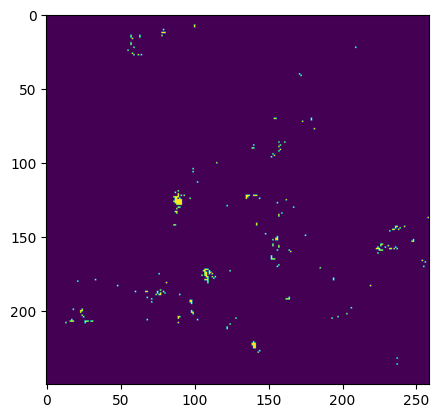

In [209]:
import matplotlib.pyplot as plt
plt.imshow(drought_maps[index])
print(list_start_end_date[index])
index+=1

In [188]:
import geopandas as gpd
import rasterio
import rasterio.features
from shapely.geometry import shape
from tqdm import tqdm
from datetime import datetime
new_directory = '/Users/arthurcalvi/Data/Disturbances_maps/Copernicus_CDI/CDI_2012_2023/france_extent'
fr = gpd.read_parquet('../data/processed_datasets/france_EPSG2154.parquet')
list_gdf = []
src = rasterio.open(os.path.join(new_directory, files[0]))
for drought, (start_date, end_date) in tqdm(zip(drought_maps, list_start_end_date)):
    drought = drought.astype('uint8')
    shapes = rasterio.features.shapes(drought, transform=src.transform)
    geoms = [shape(s) for s, val in shapes if val == 1]
    gdf = gpd.GeoDataFrame({'geometry':geoms, 'start_date': [start_date] * len(geoms), 'end_date' : [end_date] * len(geoms)}, geometry='geometry', crs=src.crs)
    gdf = gdf.to_crs('epsg:2154').clip(fr.geometry)
    list_gdf.append(gdf)

0it [00:00, ?it/s]

10it [00:07,  1.26it/s]


In [189]:
import pandas as pd 
gdf = pd.concat(list_gdf)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs='epsg:2154')

In [191]:

gdf.to_parquet('../data/processed_datasets/CDI_2012_2023.parquet')

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

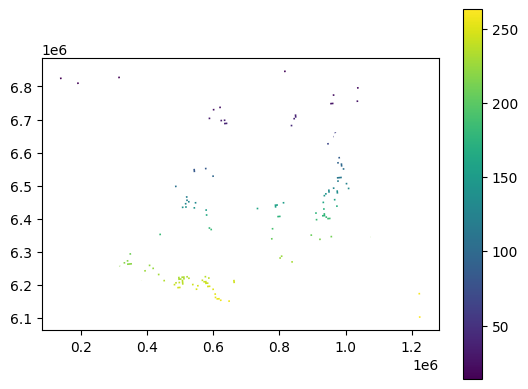

In [35]:
a = list_gdf[2]
a['index'] = a.index
a.plot(column='index', legend=True)

## simpplified version

In [192]:
import geopandas as gpd
bdforet30 = gpd.read_parquet('../data/processed_datasets/BDFORET_EPSG2154_FR_simplified30.parquet')
cdi = gpd.read_parquet('../data/processed_datasets/CDI_2012_2023.parquet')

import pandas as pd
import numpy as np

def get_tree_species(row):
    index = bdforet30.sindex.query(row.geometry, predicate='intersects')
    if len(index) == 1:
        index = index[0]
        return bdforet30.iloc[index][['tree_type', 'essence']]
    elif len(index) > 1:
        sub = bdforet30.iloc[index]
        if len(sub.tree_type.unique().tolist()) > 1:
            tree_type = 'Mixed' 
        else : 
            tree_type = sub.tree_type.iloc[0] if type(sub.tree_type.iloc[0]) == str else np.nan 
        essence = ",".join([x for x in sub.essence.unique().tolist() if type(x) == str])
        #put in a pandas series with tree_type and essence as row names
        return pd.Series([tree_type, essence], index=['tree_type', 'essence'])
    else :
        return None, None

cdi[['tree_type', 'essence']] = cdi.apply(get_tree_species, axis=1, result_type='expand')

In [193]:
cdi['class'] = 'drought'
cdi.to_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet')

In [2]:
import geopandas as gpd 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet')
# cdi['class'] = 'drought'
# cdi.to_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet')

In [3]:
cdi.shape

(44583, 6)

In [7]:
cdi['start_date'] = cdi.date
cdi['end_date'] = cdi.date
cdi.drop(columns=['date'], inplace=True)
cdi.to_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet')

In [9]:
a = cdi['geometry'].apply(lambda x: x.is_valid)

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
